In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import time
import pickle
import collections
% matplotlib inline

In [2]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
#def color_hist(img, nbins=32, bins_range=(0, 1)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# load test road data

In [3]:
test_images = sorted(glob.glob('./test_images/*.jpg'))

In [4]:
test_images

['./test_images/test1.jpg',
 './test_images/test2.jpg',
 './test_images/test3.jpg',
 './test_images/test4.jpg',
 './test_images/test5.jpg',
 './test_images/test6.jpg']

In [5]:
filenames = [f.split('/')[-1] for f in test_images ]

In [6]:
filenames

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

## user HOG_sub_sampling technique

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # use all channels, which is identical to 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if demonstration == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
            elif test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                 # Append window position to list
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def process_bboxes(image,hot_windows,threshold,show_heatmap=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    bbox_list = find_labeled_boxes(labels)
    if show_heatmap:
        return bbox_list,heatmap
    else:
        return bbox_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def find_labeled_boxes(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    return bbox_list

def draw_car_boxes(img, bbox_list):
    for bbox in bbox_list:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,255), 6)
    # Return the image
    return img

## show sample test image 

In [8]:
from utils_vehicles import showImageList

In [9]:
rand6 = np.random.permutation(range(6))
rand6

imread_op = lambda x:mpimg.imread(x)
t_images = list(map( imread_op, test_images )) 

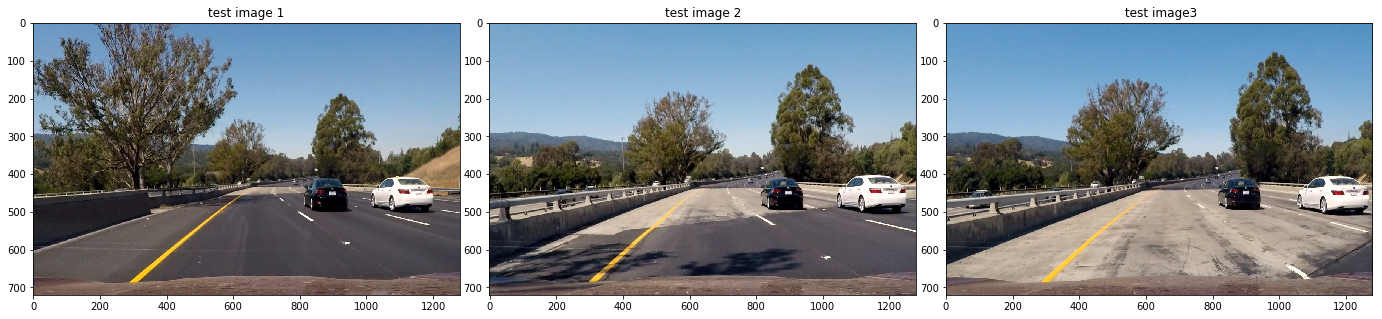

In [10]:

rgb_images = np.asarray([[ t_images[ rand6[0] ],t_images[ rand6[1] ],t_images[ rand6[2] ] ] ])
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))

In [11]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
global svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins,ystart,ystop
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
y_start_stop = [375, 640]

In [12]:
ystart, ystop = y_start_stop[0], y_start_stop[1]

In [13]:
print("orient:%s" %  orient)
print("pix_per_cell : %s" % pix_per_cell)
print("cell_per_block : %s" % cell_per_block)
print("spatial_size : " , spatial_size)
print("hist_bins : %s" % hist_bins)
print("y_start_stop : %s" % y_start_stop)

orient:9
pix_per_cell : 8
cell_per_block : 2
spatial_size :  (16, 16)
hist_bins : 128
y_start_stop : [375, 640]


## display all boxes on test images how box are build based on scale.

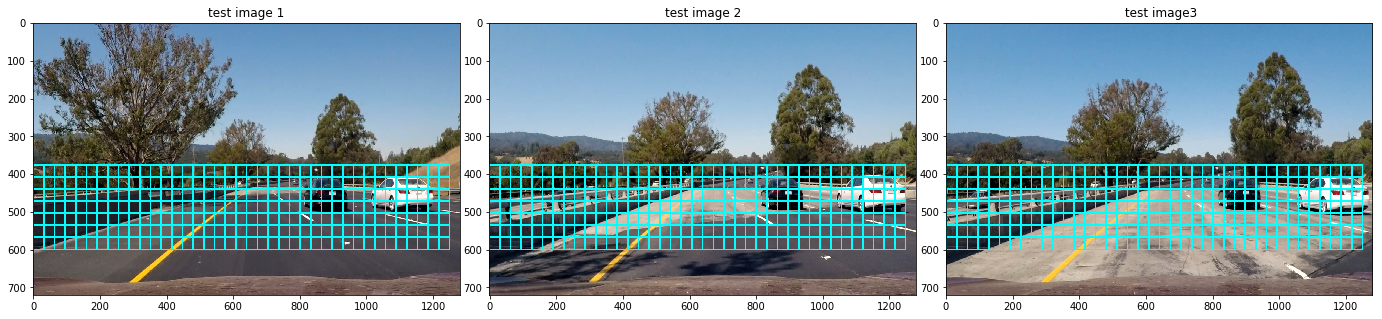

In [14]:
scale = 2

result_windows = []
for i in range(3):
    
    sample_image = t_images[rand6[i]].copy()
    
    hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=True)
    result_window = draw_boxes(sample_image, hot_windows, color=(0, 255, 255), thick=3)
    result_windows.append(result_window)
    
rgb_images = np.asarray([[ result_windows[0] ,result_windows[1] ,result_windows[2] ] ])
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))    


## now scaleing size is shrinked so that objets located on far points of image are easily detected.

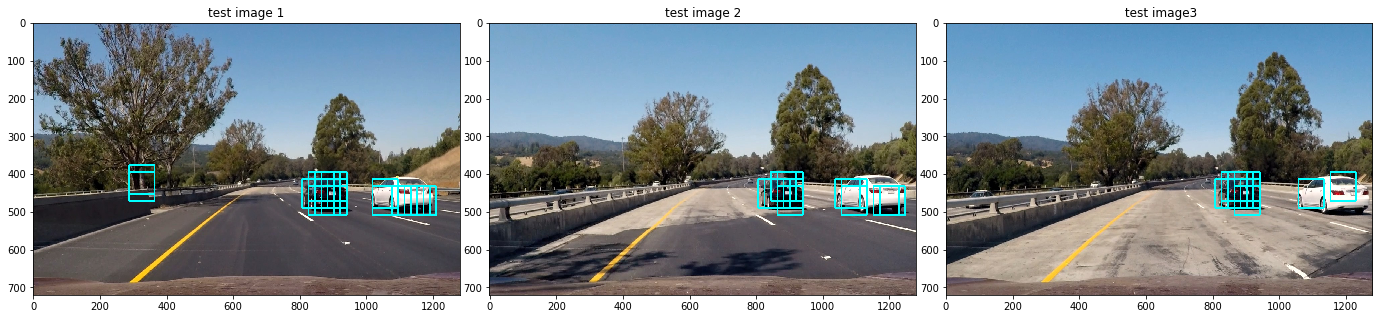

In [15]:
scale = 1.2


result_windows = []
for i in range(3):
    
    sample_image = t_images[rand6[i]].copy()
    
    hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False)
    result_window = draw_boxes(sample_image, hot_windows, color=(0, 255, 255), thick=3)
    result_windows.append(result_window)
    
rgb_images = np.asarray([[ result_windows[0] ,result_windows[1] ,result_windows[2] ] ])
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))    


## setup multi scaling to detect any sized objects in anywhere points (farest / nearest points) 

founded box number based SVC .. 51
founded box number based SVC .. 38
founded box number based SVC .. 36


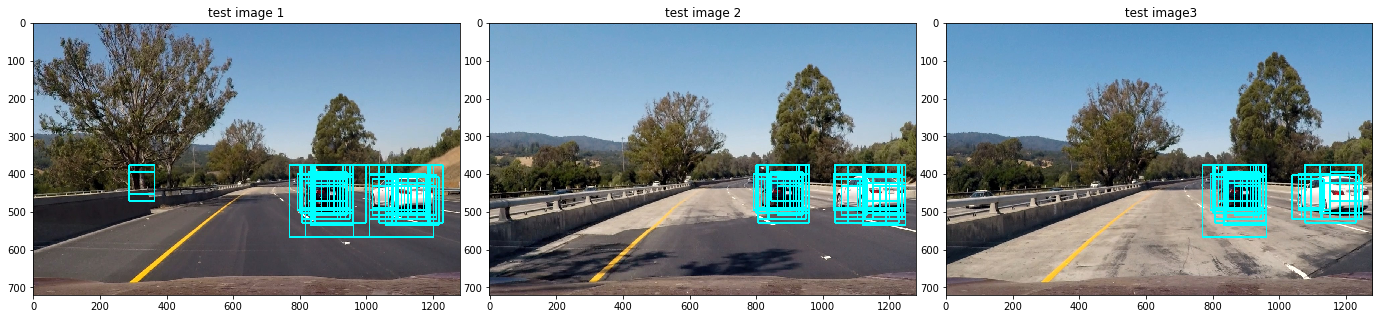

In [16]:

scales = [1,1.2,1.5,1.8,2,2.4,3]

result_windows = []
for i in range(3):
    
    sample_image = t_images[rand6[i]].copy()

    tmp_windows = []
    for scale in scales:
        hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False)
        tmp_windows = hot_windows + tmp_windows
    print("founded box number based SVC ..",len(tmp_windows))        
    
    result_window = draw_boxes(sample_image, tmp_windows, color=(0, 255, 255), thick=3)
    result_windows.append(result_window)
    
rgb_images = np.asarray([[ result_windows[0] ,result_windows[1] ,result_windows[2] ] ])
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))    


## Draw Heatmap to mark Car objects found on image

In [17]:
heatnames = [" heat : on " + f.split('.')[0]  for f in filenames]
detectnames = [" Detect Car : on " + f.split('.')[0] for f in filenames]

print(heatnames)
print(detectnames)

[' heat : on test1', ' heat : on test2', ' heat : on test3', ' heat : on test4', ' heat : on test5', ' heat : on test6']
[' Detect Car : on test1', ' Detect Car : on test2', ' Detect Car : on test3', ' Detect Car : on test4', ' Detect Car : on test5', ' Detect Car : on test6']


founded box number based SVC .. 36
founded box number based SVC .. 1
founded box number based SVC .. 5
founded box number based SVC .. 38
founded box number based SVC .. 47
founded box number based SVC .. 51


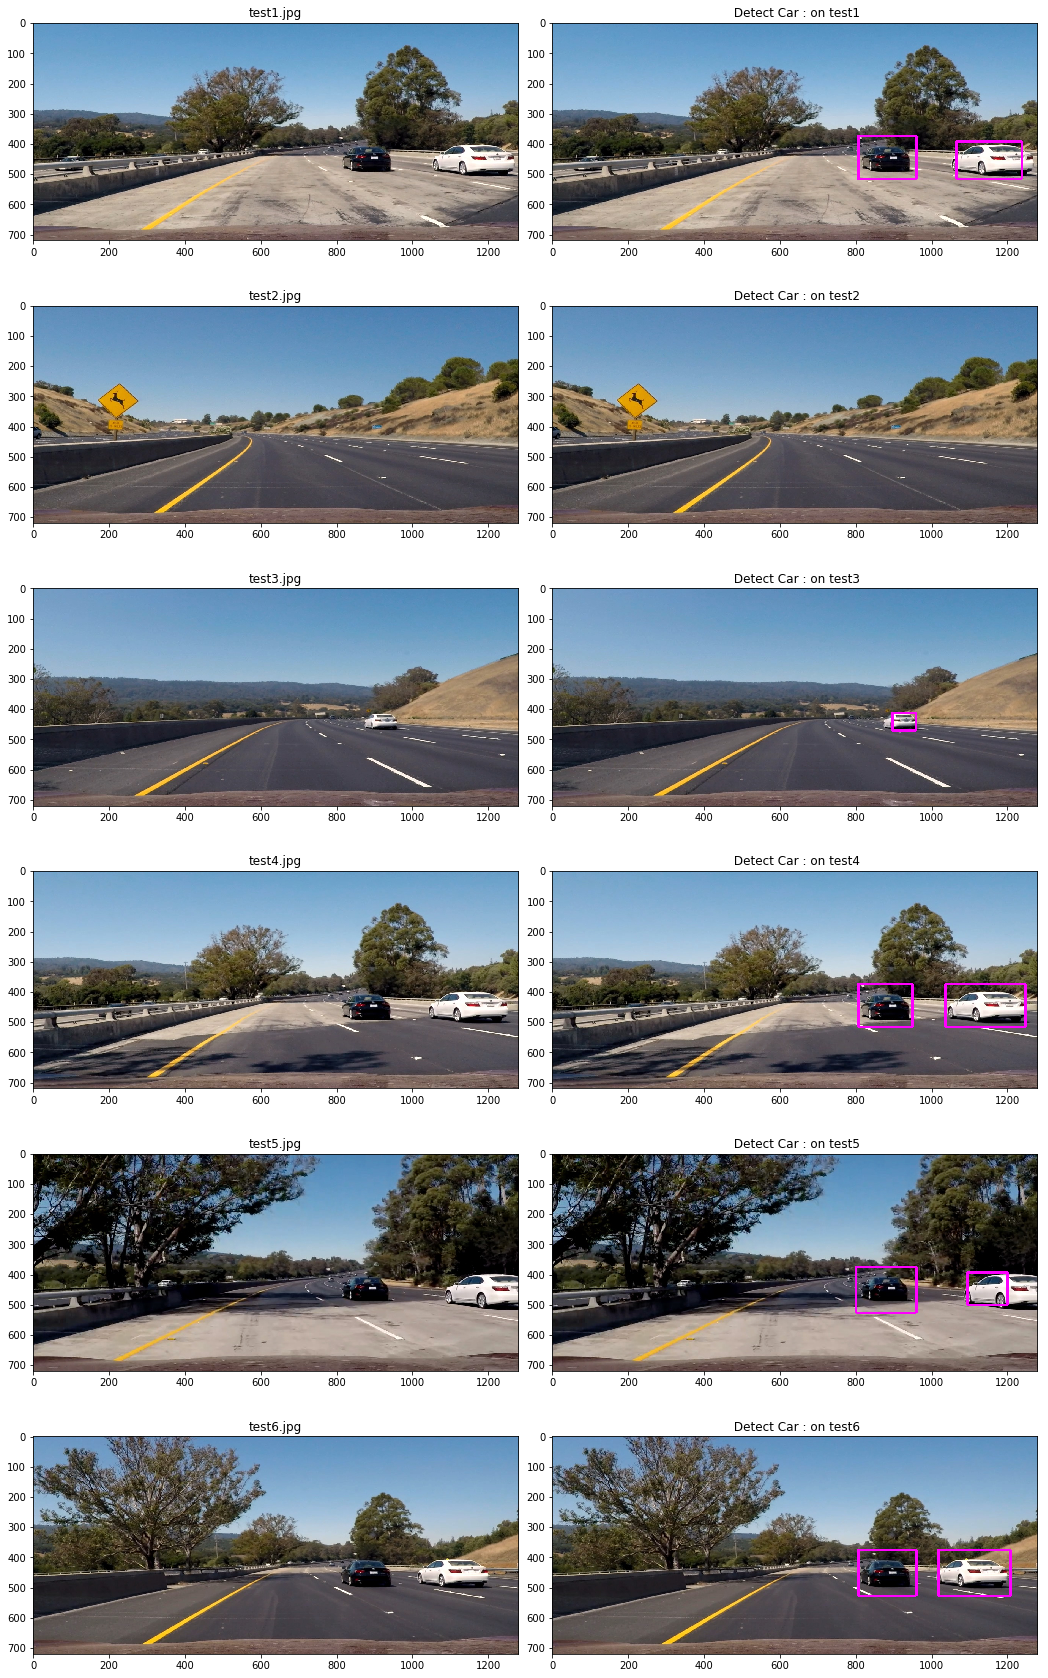

In [18]:


scales = [1,1.2,1.5,1.8,2,2.4,3]

result_windows = []
heatmaps = []
objectDetections = []

for i in range(6):
    
    sample_image = t_images[i].copy()

    tmp_windows = []
    for scale in scales:
        hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False)
        tmp_windows = hot_windows + tmp_windows
    print("founded box number based SVC ..",len(tmp_windows))        
    
    # multi boxes drawn on raw image ...
    result_window = draw_boxes(sample_image, tmp_windows, color=(0, 255, 255), thick=3)
    result_windows.append(result_window)

    # draw heat map 
    bbox_list,heatmap = process_bboxes(sample_image,tmp_windows,threshold=3,show_heatmap=True)
    draw_img = draw_car_boxes(sample_image, bbox_list)
    
    heatmaps.append(heatmap)
    objectDetections.append(draw_img)
    
    
images_list =  np.asarray(list( zip( t_images, objectDetections) ))
images_label =  np.asarray(list( zip(filenames , detectnames ) ))

showImageList(images_list, images_label,cols=2, fig_size=(18,30))    

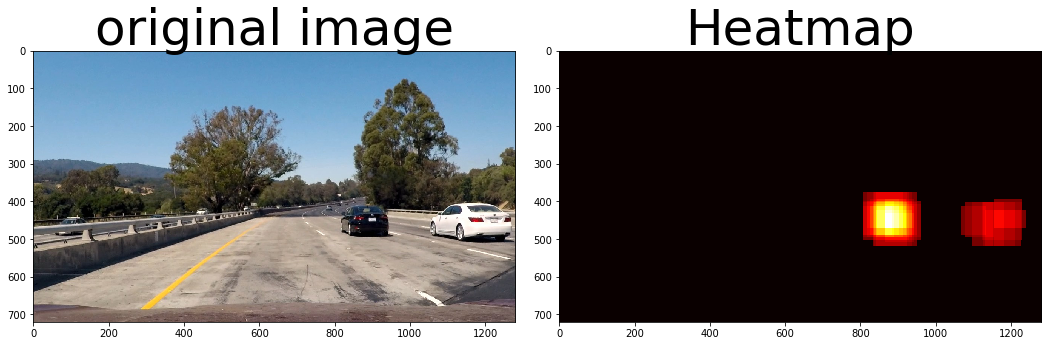

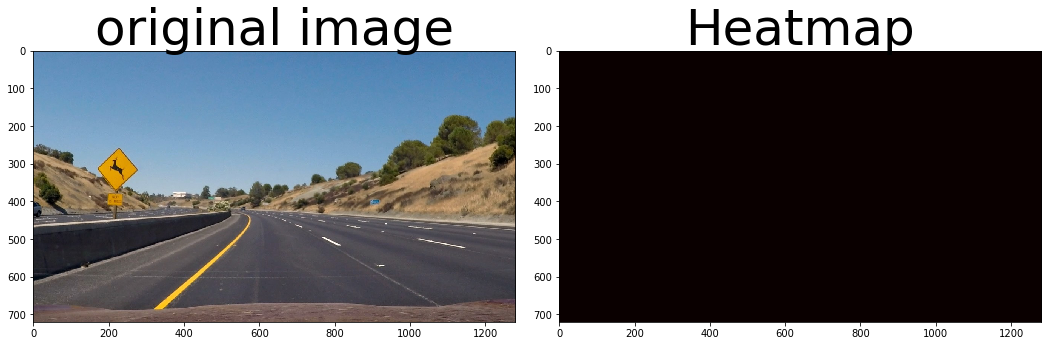

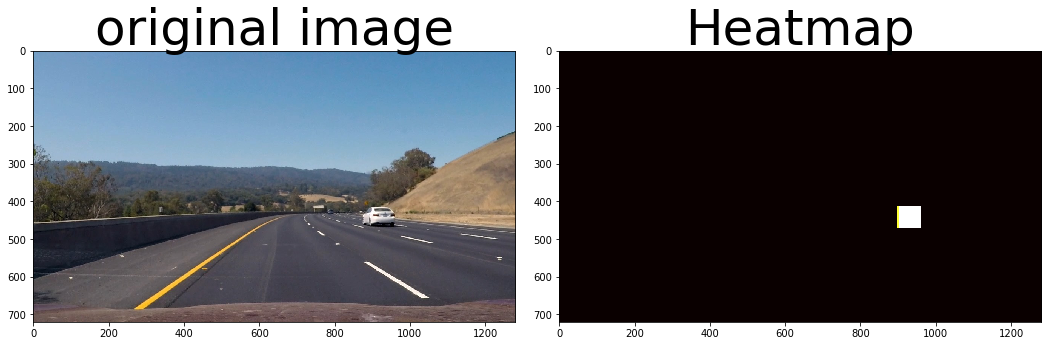

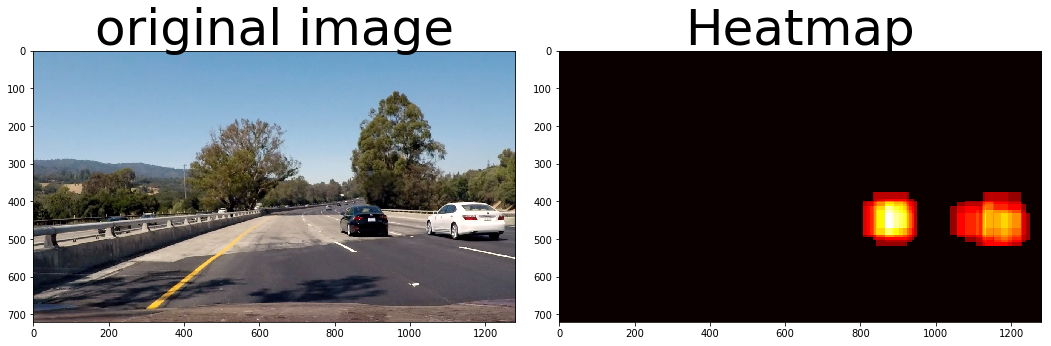

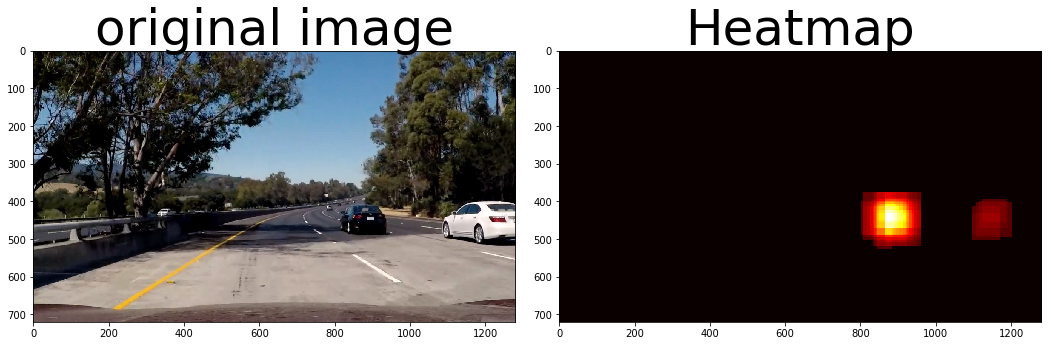

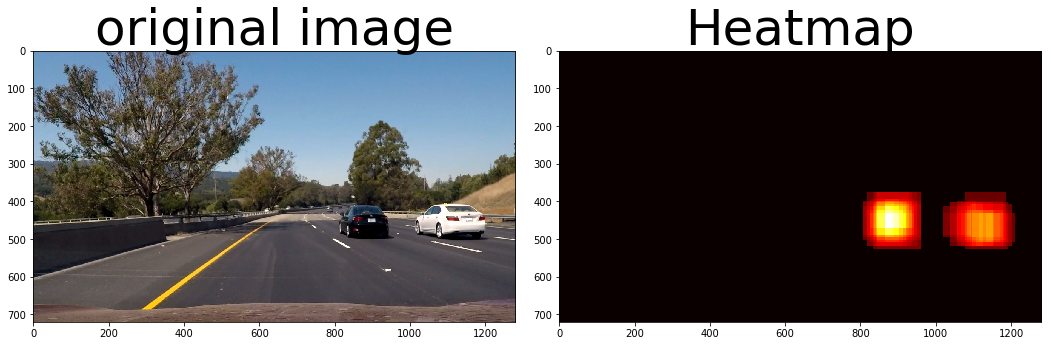

In [19]:
for im, h in zip(t_images,heatmaps):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    f.tight_layout()
    ax1.imshow(im)
    ax1.set_title('original image', fontsize=50)
    ax2.imshow(h,cmap='hot')
    ax2.set_title('Heatmap', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)      

## Pipeline process

In [20]:
def detect_car_pipeline(image):

    scales = [1,1.2,1.5,1.8,2,2.4,3]

    sample_image = image.copy()
    tmp_windows = []
    for scale in scales:
        hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False)
        tmp_windows = hot_windows + tmp_windows
    #print("founded box number based SVC ..",len(tmp_windows))        
    
    # multi boxes drawn on raw image ...
    #result_window = draw_boxes(sample_image, tmp_windows, color=(0, 255, 255), thick=3)
    #result_windows.append(result_window)

    # draw heat map 
    bbox_list = process_bboxes(sample_image,tmp_windows,threshold=1,show_heatmap=False)
    draw_img = draw_car_boxes(sample_image, bbox_list)
    
    return draw_img
    #heatmaps.append(heatmap)
    #objectDetections.append(draw_img)

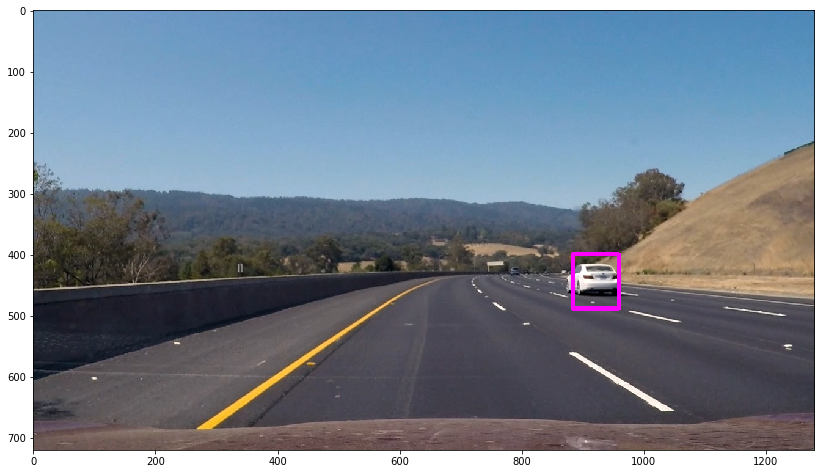

In [21]:
#
## test piplelie process to confirm car object is detected.
#
result = detect_car_pipeline(t_images[2])
plt.figure(figsize=(14,9) )
plt.imshow(result)

In [72]:
from collections import deque
from itertools import chain



## defining a class to keep track of the previous bounding boxes
class VDetector:
    
    clf = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]    
    
    scales = [1,1.2,1.5,1.8,2,2.4,3]

    ## initial list of variables to be passed in
    y_start_stop = [375, 640]
    color_space = 'YCrCb'
    hog_channel = True
    spatial_feat = True
    color_feat = True
    hog_feat = True
    
    ## initialize variables
    def __init__(self, frames_to_keep=10):
        self.hotbox_hist = deque(maxlen=frames_to_keep)
    
    def pipeline(self,image):
        sample_image = image.copy()
        
        tmp_windows = []
        for scale in scales:
            hot_windows = find_cars(sample_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False)
            tmp_windows = hot_windows + tmp_windows
        #print("founded box number based SVC ..",len(tmp_windows))        

        # multi boxes drawn on raw image ...
        #result_window = draw_boxes(sample_image, tmp_windows, color=(0, 255, 255), thick=3)
        #result_windows.append(result_window)

        # draw heat map 
        bbox_list = process_bboxes(sample_image,tmp_windows,threshold=1,show_heatmap=False)
        
        ## process for previouse frame of video images
        self.hotbox_hist.append(bbox_list)
        #
        heatmap_mask = np.zeros_like(sample_image[:,:,0]).astype(np.float)  
        # Add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, list(chain.from_iterable(self.hotbox_hist)))
        # Apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,threshold=1)
        # Visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heat_img)
        #draw_img = draw_labeled_bboxes(np.copy(image), labels)
        bbox_list = find_labeled_boxes(labels)        
        draw_img = draw_car_boxes(sample_image, bbox_list)
        

        return draw_img

In [73]:
vd = VDetector()

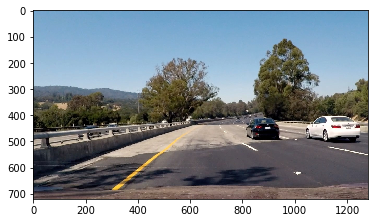

In [74]:
res = vd.pipeline(t_images[3])
plt.imshow(res)

In [75]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [76]:
vd = VDetector()
video_output = 'output_images/test_video_found.mp4'
clip1 = VideoFileClip('test_video.mp4')
video_clip = clip1.fl_image(vd.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_found.mp4
[MoviePy] Writing video output_images/test_video_found.mp4


 97%|█████████▋| 38/39 [01:25<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_found.mp4 

CPU times: user 1min 23s, sys: 2.64 s, total: 1min 25s
Wall time: 1min 26s


In [77]:
vd = VDetector()
video_output = 'output_images/project_video_found.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(vd.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_found.mp4
[MoviePy] Writing video output_images/project_video_found.mp4


100%|█████████▉| 1260/1261 [46:49<00:02,  2.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_found.mp4 

CPU times: user 45min 36s, sys: 1min 24s, total: 47min 1s
Wall time: 46min 50s
